In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import base64  
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
import keras
from keras.models import Sequential
from keras.layers import Dense
from IPython.display import HTML
import xgboost as xgb
from xgboost import plot_importance

def create_download_link( csv, title = "Download CSV file", filename = "data.csv"):  
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)


Import CSV and define dataframe / testframe / targetframe

In [0]:
url = 'https://raw.githubusercontent.com/juanroldanbrz/SmartEngineer/master/train_data.csv'
df_train, df_test = train_test_split(pd.read_csv(url), test_size=0.2)

Detect amount of null values

In [0]:
df_train.isnull().sum()

T     0
V     0
P     0
RH    0
E     0
dtype: int64

In [0]:
df_train.describe()

,T,V,P,RH,E
count,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,256.651037,325.680488,92.105988,44.210919,1816.409550
std,94.290542,76.209834,0.538250,8.813968,65.929779
min,47.190000,152.160000,90.260000,15.530000,1700.560000
25%,178.490000,251.520000,91.720000,37.967500,1758.990000
50%,265.655000,308.190000,92.080000,45.135000,1808.800000
75%,334.782500,398.640000,92.480000,51.160000,1870.250000
max,455.390000,481.080000,93.890000,60.090000,1969.840000


Display pair plots

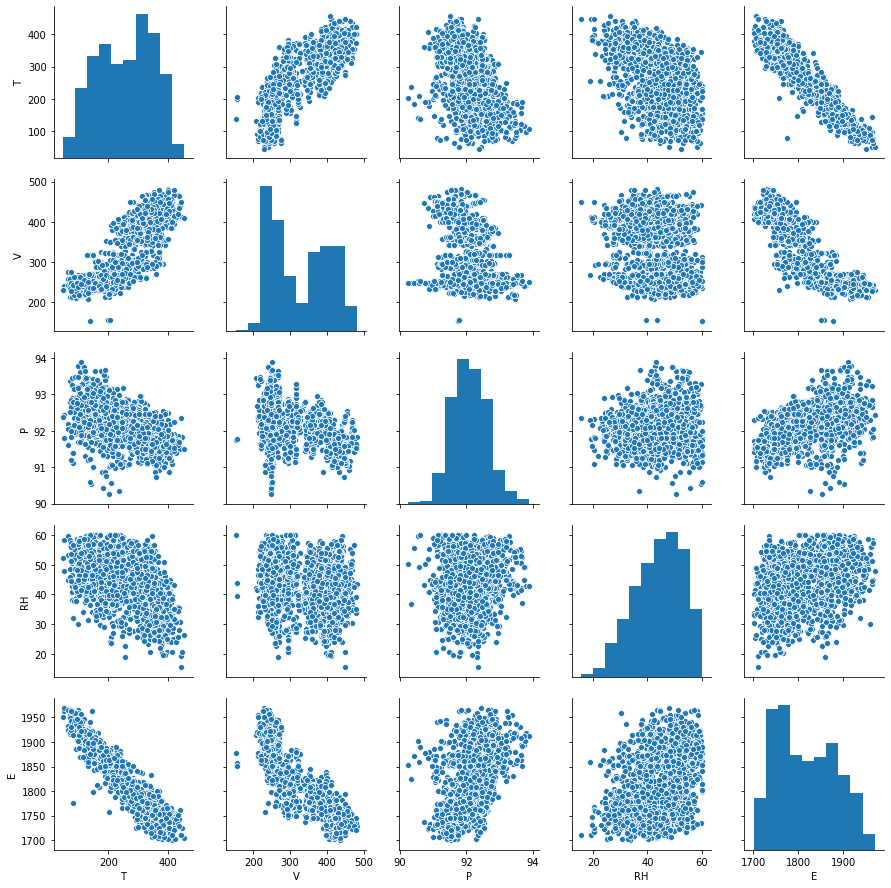

In [0]:
sns.pairplot(df_train)

In [0]:
correlations_to_energy = df_train.corr()['E']
correlations_to_energy

T    -0.945878
V    -0.871306
P     0.507362
RH    0.374521
E     1.000000
Name: E, dtype: float64

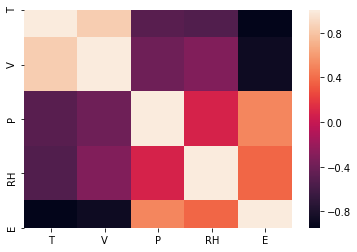

In [0]:
sns.heatmap(df_train.corr())

Prepare models

In [0]:
def normalize_dataframe(df):
  df_values = df.copy().values
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(df_values)
  return pd.DataFrame(x_scaled)

In [0]:
features = ['T', 'P', 'RH']
X = normalize_dataframe(pd.DataFrame(df_train, columns=features))
Y = df_train['E']
X_test = normalize_dataframe(pd.DataFrame(df_test, columns=features))
Y_test = df_test['E']

X_np = X.to_numpy()
Y_np = Y.to_numpy()
X_test_np = X_test.to_numpy()
Y_test_np = Y_test.to_numpy()

print(X.describe())

def rmse(arr1, arr2):
    return np.sqrt(np.mean((arr1-arr2)**2))


                 0            1            2
count  1600.000000  1600.000000  1600.000000
mean      0.513133     0.508537     0.643647
std       0.230991     0.148278     0.197800
min       0.000000     0.000000     0.000000
25%       0.321656     0.402204     0.503535
50%       0.535191     0.501377     0.664385
75%       0.704538     0.611570     0.799596
max       1.000000     1.000000     1.000000


Linear model

RMSE for Linear Regression Model in sklearn: 18.73


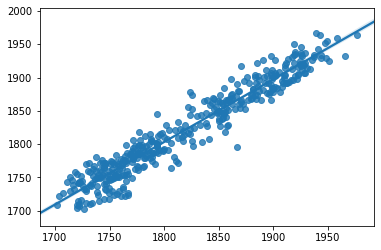

In [0]:
linear_model = LinearRegression()
linear_model.fit(X_np, Y_np)
Y_test_predict = linear_model.predict(X_test_np)
rmse_linear = rmse(Y_test_np, Y_test_predict)
sns.regplot(Y_test_np, Y_test_predict)
print("RMSE for Linear Regression Model in sklearn: %.2f" % rmse_linear)


Neural Network in Keras using Tensorflow backend



In [0]:
def baseline_nn_model(dims):
    model = Sequential()
    model.add(Dense(dims, input_dim=dims,kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def larger_nn_model(dims):
    model = Sequential()
    model.add(Dense(dims, input_dim=dims,kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def use_keras_nn_model(nn_model, x, y, xx, yy, epoch):
    print("start training")
    for step in range(epoch + 1):
        cost = nn_model.train_on_batch(x, y)
        if step % 100 == 0:
            print("train cost: %.2f" % cost)
    print("start testing")
    yy_predict = nn_model.predict(xx).reshape(len(yy),)
    res = rmse(yy, yy_predict)
    sns.regplot(yy, yy_predict)
    print("RMSE for NN Model in Keras(Tensorflow): %.2f" % res)
    return res

start training
train cost: 3303688.25
train cost: 3302500.50
train cost: 3288169.50
train cost: 3211916.50
train cost: 2988917.75
train cost: 2535966.50
train cost: 1844162.25
train cost: 1055175.25
start testing
RMSE for NN Model in Keras(Tensorflow): 1078.01


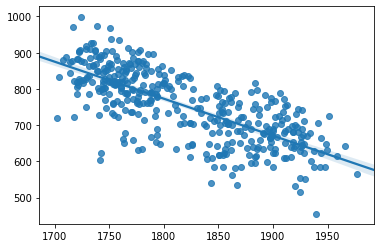

In [0]:

rmse_baselinenn = use_keras_nn_model(larger_nn_model(X_np.shape[1]), X_np, Y_np, X_test_np, Y_test_np, 700)


XBoost Model

RMSE for xgboost: 29.61


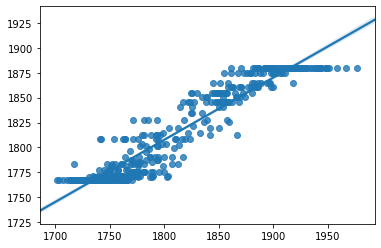

In [0]:
params = {
    'booster': 'gbtree',
    'objective': 'reg:gamma',
    'gamma': 0.1,
    'max_depth': 5,
    'lambda': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'silent': 1,
    'eta': 0.1,
    'seed': 1000,
    'nthread': 4,
}

plst = params.items()
dtrain = xgb.DMatrix(X_np, Y_np)
dtest = xgb.DMatrix(X_test_np)
num_rounds = 500
xgb_model = xgb.train(plst, dtrain, num_rounds)
yt_xgb = xgb_model.predict(dtest)
rmse_xgb = rmse(Y_test_np, yt_xgb)
sns.regplot(Y_test_np, yt_xgb)
print("RMSE for xgboost: %.2f" % rmse_xgb)


Render solution

In [0]:
test_url = 'https://raw.githubusercontent.com/juanroldanbrz/SmartEngineer/master/test_data.csv'
df_test = pd.read_csv(test_url)
X_test_np = normalize_dataframe(pd.DataFrame(df_test, columns=features))
predictions = linear_model.predict(X_test_np)

df_test.insert(X_test_np.shape[1] + 1, 'E', predictions, True)
create_download_link(df_test.to_csv(index=False))

